# The Conjugate Gradient Method

> Notes from the Medical Vision Group's summer reading of _Numerical Optimization. J. Nocedal, Stephen J. Wright, 1999._

The goal of this notebook is
1. To derive the conjugate gradient method, and 
2. Explain the connection between eigenvalues and the convergence rate.

## Setup

The goal of the conjugate gradient algorithm is to iteratively solve linear systems of the form

$$Ax = b \,,$$

where **we assume that $A \in \mathbb{R}^{n \times n}$ is symmetric positive definite.**

It turns out that solving such a linear system is equivalent to minimizing the quadratic form

$$f(x) = x^TAx - b^Tx + c \,.$$

To see this, look at its gradient: 

$$\nabla f(x) = Ax - b \,.$$

The gradient equals zero exactly at the $x=x^*$ that minimizes the the residual of the linear system $r(x^*) = b - Ax^* \,.$
(Additionally, the Hessian matrix of $f$ is $A$, which is positive definite, so it has exactly one optimal point!)
Since the conjugate gradient method is an iterative one, we will write that the $k$-th iterate $x_k$ has a residual of $r_k = -\nabla f(x_k) =  b - Ax_k$.

To minimize the quadratic form, we _could_ use steepest descent, which is gradient descent where you take the largest step possible to minimize the loss. 
However, for certain linear systems, gradient descent converges very slowly (_slowly_ here means that the number of steps needed for convergence is $\gg n$, the dimension of $A$).
Instead, conjugate gradient gives an iterative optimization that is guaranteed to converge in at most $n$ steps (in exact arithmatic; floating point accuracy means it can take a little longer, but it's still faster than gradient descent).

## Understanding conjugacy

In essence, the conjugate gradient method is simply a change of basis.
However, the basis we seek is very special:
specifically, we are looking for a set of basis vectors that are _conjugate_ with respect to $A$.
Two vectors $u$ and $v$ are conjugate if they satisfy a special kind of orthogonality:

$$ u^T A v = v^T A v = 0 \,.$$

This means that after $u$ ($v$) is transformed by $A$, it is orthogonal to $v$ ($u$).
This basis is very useful for finding the solution to a linear system, as we'll show below.
First, a quick lemma:

**Lemma 1.** If $u$ and $v$ are conjugate with respect to $A$, then they are also linearly independent.
\
_Proof:_ TODO :)

Suppose that we have a conjugate basis $\{p_1, \dots, p_n\}$ with respect to $A$.
Since these vectors are linearly independent, we can express $x^*$ as

$$ x^* = \alpha_1 p_1 + \cdots + \alpha_n p_n \implies Ax^* = b = \alpha_1 Ap_1 + \cdots + \alpha_n Ap_n \,. $$

Premultiplying by the vector $p_k$, we see that

$$ p_k^T b = \alpha_k p_k^T A p_k \,, $$

since the other terms cancel out by conjugacy! Therefore, we have that the coefficients are

$$ \alpha_k = \frac{p_k^T b}{p_k^T A p_k} \,, $$

which are all quantities we know how to compute. That is, changing our basis to a conjugate one makes it very easy to solve a linear system.

This simple results tells us two important facts:
1. If we have a procedure that produces a conjugate basis vector at each step, we can solve a linear system in at most $n$ steps.
2. If we have a set of conjugate basis vectors for $A$, it is trivial to solve a linear system. The brilliance of the conjugate gradient method is in how we find these vectors.

Before discussing the generating procedure, it's useful to visualize conjugacy and our loss landscape.

In [1]:
using LinearAlgebra
using Plots

Since we are working with positive definite matrices, it's useful to have a function to randomly generate them.
The procedure we use leverages the fact that $A^T A$ is gauranteed to be a positive semidefinite matrix (use the definition of positive semidefiniteness to prove this). Note that $A^T A$ is positive semidefinite iff $A$ has rank less than $n$, and the probability of this happening is very small. Therefore, we almost always generate a positive definite matrix by samping a random square matrix and premultiplying it by its transpose.

In [2]:
# Sample a random PSD matrix
function random_psd(n::Int64=2)
    A = randn(n, 2)
    return A' * A
end

random_psd (generic function with 2 methods)

Next, we plot the level sets of the quadratic form defined by our positive definite $A$.
That is, we visualize multiple elliptical curves along which $x^TAx = c$ for some constant $c$.
These let us visualize the loss landscape we are trying to optimize.

In [3]:
# Plot the level sets of the isoclines of a PSD matrix
function plot_ellipse(A::Matrix{Float64}; t=LinRange(0, 2π, 100), c=:gray)

    # Get the trace for the ellipse with radius 1
    trace_ellipse(t) = V' * @. sqrt(Λ) * [sin(t) cos(t)]'
    Λ, V = eigen(A)
    ellipse = trace_ellipse(t)
    ellipse_x, ellipse_y = [ellipse[i, :] for i in 1:length(Λ)]

    # Draw ellipses with many radii
    p = plot(ellipse_x, ellipse_y, c=c, legend=false, aspect_ratio=:equal)
    for r in LinRange(1, 1.75, 3)
        plot!(p, r .* ellipse_x, r .* ellipse_y, c=c)
    end
    
    # Draw the principle axes
    scaled_axes = V .* Λ'
    x1, x2 = [scaled_axes[:, i] for i in 1:length(Λ)]
    plot!(p, ([0, x1[1]], [0, x1[2]]))
    plot!(p, ([0, x2[1]], [0, x2[2]]))
    
    # Make the title the condition number
    λ₁, λ₂ = sort(Λ, rev=true)
    κ = λ₁ / λ₂ |> κ -> round(κ; digits=2)
    title!("κ=$κ")
    return p
end

plot_ellipse (generic function with 1 method)

The final concept we will discuss with these curves is the **condition number**. The condition number is the ratio between the largest and smallest eigenvalues. When this number is small (i.e., closer to 1), the closer the ellipses are to a circle (_left_). This corresponds to a system that is more amenable to gradient descent: you can pick any direction to descent and make good progress. For a system with a large condition number, some directions are much more fruitful than others. This means gradient descent can take a very long time if you choose a poor starting point for the optimization.

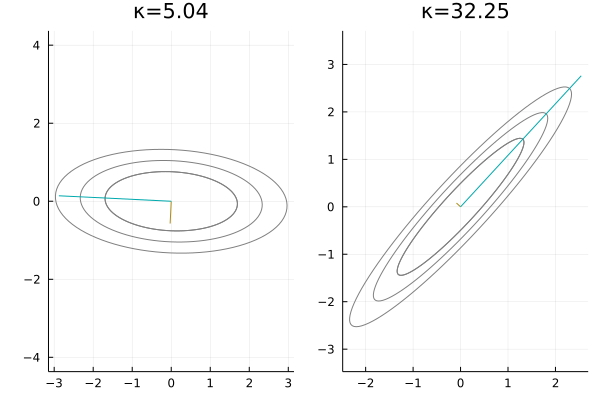

In [4]:
p1 = random_psd(2) |> plot_ellipse
p2 = random_psd(2) |> plot_ellipse
plot(p1, p2, layout=2)

## Deriving the conjugate gradient method



In [5]:
function slow_conjgrad(A::Matrix{Float64}, b::Vector{Float64}, x::Vector{Float64})

    r = A * x - b
    p = -r

    k = 1
    error = Float64[]

    while norm(r) > 10e-6
        push!(error, norm(r))
        α = -(r' * p) / (p' * A * p)
        x = x + α * p
        r = A * x - b
        β = (r' * A * p) / (p' * A * p)
        p = -r + β * p
        k += 1
    end
    
    return x, k, error

end

slow_conjgrad (generic function with 1 method)

In [6]:
function fast_conjgrad(A::Matrix{Float64}, b::Vector{Float64}, x::Vector{Float64})
    
    r = A * x - b
    p = -r
    
    k = 1
    error = Float64[]

    while norm(r) > 10e-6
        push!(error, r'*A*r)
        α = (r' * r) / (p' * A * p)
        x = x + α * p
        
        r_old = deepcopy(r)
        r = r_old + α * A * p
        
        β = (r' * r) / (r_old' * r_old)
        p = -r + β * p
        k += 1
    end
    
    return x, k, error

end

fast_conjgrad (generic function with 1 method)

In [7]:
function energy(A::Matrix{Float64}, x::Vector{Float64})
    return x' * A * x
end


function wiki_conjgrad(A::Matrix{Float64}, b::Vector{Float64}, x::Vector{Float64}; tol::Float64=10e-6)
    k = 0
    r = b - A * x
    p = r
    rsold = r' * r
    
    while sqrt(rsold) > tol
        Ap = A * p
        α = rsold / (p' * Ap)
        x += α * p
        r -= α * Ap
        rsnew = r' * r
        if sqrt(rsnew) < tol
            break
        end
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        k += 1
    end
    
    return x, k, nothing
end

wiki_conjgrad (generic function with 1 method)

In [8]:
A(n::Int64) = [1 / (i + j - 1) for i=1:n, j=1:n]  # Hilbert matrix
b(n::Int64) = ones(n)  # Target
x(n::Int64) = zeros(n)  # Initial guess

x (generic function with 1 method)

In [9]:
using BenchmarkTools

for n in [5, 8, 12, 20]
    @show n
    _, k₁, _ = @btime slow_conjgrad(A($n), b($n), x($n))
    _, k₂, _ = @btime fast_conjgrad(A($n), b($n), x($n))
    _, k₃, _ = @btime wiki_conjgrad(A($n), b($n), x($n))
    @show k₁, k₂, k₃
end

n = 5
  2.208 μs (68 allocations: 6.48 KiB)
  2.292 μs (80 allocations: 8.45 KiB)
  1.225 μs (45 allocations: 4.38 KiB)
(k₁, k₂, k₃) = (7, 7, 5)
n = 8
  10.875 μs (289 allocations: 36.66 KiB)
  7.667 μs (237 allocations: 31.64 KiB)
  4.137 μs (136 allocations: 17.44 KiB)
(k₁, k₂, k₃) = (29, 20, 18)
n = 12
  15.125 μs (319 allocations: 50.91 KiB)
  10.208 μs (261 allocations: 42.17 KiB)
  5.306 μs (143 allocations: 23.41 KiB)
(k₁, k₂, k₃) = (32, 22, 19)
n = 20
  54.000 μs (730 allocations: 163.77 KiB)
  23.917 μs (417 allocations: 90.34 KiB)
  12.500 μs (234 allocations: 54.22 KiB)
(k₁, k₂, k₃) = (73, 35, 32)


## Clustered eigenvalues

In [10]:
# Really look into clustered eigenvalues
# Is the rate of progress related to eigenvalue clusters?
using Plots

In [11]:
m = 10
S = randn(m, m)
uniform = S * diagm(1:m) / S
clust_2 = S * diagm([0.9, 1., 1.1, 1.5, 2.1, 28.8, 28.9, 29.2, 29.3, 210.1]) / S
clust_3 = S * diagm([0.9, 1., 1.1, 5.5, 5.8, 26.1, 28.9, 29.2, 29.3, 210.1]) / S ;

In [12]:
_, _, error = fast_conjgrad(uniform, b(m), x(m))
plot(error, label="uniform")

_, _, error = fast_conjgrad(clust_2, b(m), x(m))
plot!(error, label="clust_2")

_, _, error = fast_conjgrad(clust_3, b(m), x(m))
plot!(error, label="clust_3")

LoadError: InterruptException: